# Time-series prediction of renewable energy production

In [92]:
from datetime import datetime, timedelta
from app.tasks.generation import generation as generation_task
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter

In [3]:
# display plots inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 5.0)
# fix seed to make results reproducible
np.random.seed(7)

In [4]:
data = pd.read_csv('../data/generation_2017.csv').set_index('timestamp')

In [5]:
def split_train_test(ds, ratio=2/3):
    train_length = int(ratio * len(ds))
    return ds[:train_length], ds[train_length:]
    
def create_datasets(ds, lookback=1):
    """
    Create two datasets for training: X = input, Y = output.
    Y is just a time-shifted version of X. The lookback argument
    tells us how many samples to scan back.
    """
    acc_x, acc_y = [], []
    for i in range(len(ds) - lookback):
        acc_x.append(ds[i:i + lookback])
        acc_y.append(ds[i + lookback])
    return np.array(acc_x), np.array(acc_y)


In [84]:
lookback = 5
model_df = data[['renewables', 'non_renewables']]
dataset = model_df.as_matrix()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_ds, test_ds = split_train_test(dataset)
train_x, train_y = create_datasets(train_ds, lookback)
test_x, test_y = create_datasets(test_ds, lookback)

In [101]:
model = Sequential()
model.add(LSTM(32, input_shape=(lookback, 2)))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(train_x, train_y, epochs=50, batch_size=16, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 32)                4480      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 66        
Total params: 4,546
Trainable params: 4,546
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 4s - loss: 0.0151
Epoch 2/50
 - 2s - loss: 0.0045
Epoch 3/50
 - 2s - loss: 0.0025
Epoch 4/50
 - 2s - loss: 0.0019
Epoch 5/50
 - 2s - loss: 0.0016
Epoch 6/50
 - 2s - loss: 0.0013
Epoch 7/50
 - 2s - loss: 0.0012
Epoch 8/50
 - 2s - loss: 0.0011
Epoch 9/50
 - 2s - loss: 0.0011
Epoch 10/50
 - 2s - loss: 0.0011
Epoch 11/50
 - 2s - loss: 0.0010
Epoch 12/50
 - 2s - loss: 9.9459e-04
Epoch 13/50
 - 2s - loss: 9.6488e-04
Epoch 14/50
 - 2s - loss: 9.4229e-04
Epoch 15/50
 - 2s - loss: 9.6101e-04
Epoch 16/50
 - 2s - loss: 9.3791e-

In [102]:
train_score = model.evaluate(train_x, train_y, verbose=0)
print(f'Train Score: {train_score:.2} MSE ({math.sqrt(train_score):.2} RMSE)')
test_score = model.evaluate(test_x, test_y, verbose=0)
print(f'Test Score: {test_score:.2} MSE ({math.sqrt(test_score):.2} RMSE)')


Train Score: 0.0009 MSE (0.03 RMSE)
Test Score: 0.0012 MSE (0.035 RMSE)


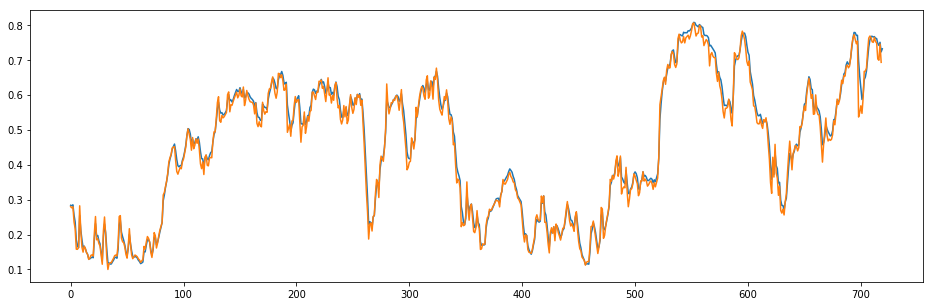

In [123]:
test_predict = model.predict(test_x)
test_predict_mw = scaler.inverse_transform(test_predict)
test_predict_ratio = [renewables / (renewables + non_renewables) for renewables, non_renewables in test_predict_mw]

real = model_df[-720:].apply(pd.Series).reset_index(drop=True)
real['ratio'] = real['renewables'] / (real['renewables'] + real['non_renewables'])

plt.plot(real['ratio'])
plt.plot(test_predict_ratio[-719:])
plt.show()

In [104]:
def extend_prediction(model, x, t=1):
    """Returns X suitable for predicting t+1"""
    rows, lookback, _ = x.shape
    assert t < lookback, "Resulting X must retain at least one non-predicted value"
    x_t = x.copy()
    roll_one = lambda arr: np.roll(arr, -1, axis=1)
    for i in range(1, t + 1):
        p = model.predict(x_t)
        x_t = roll_one(x_t)
        for row in range(rows):
            x_t[row, 2] = p[row]
    return model.predict(x_t)

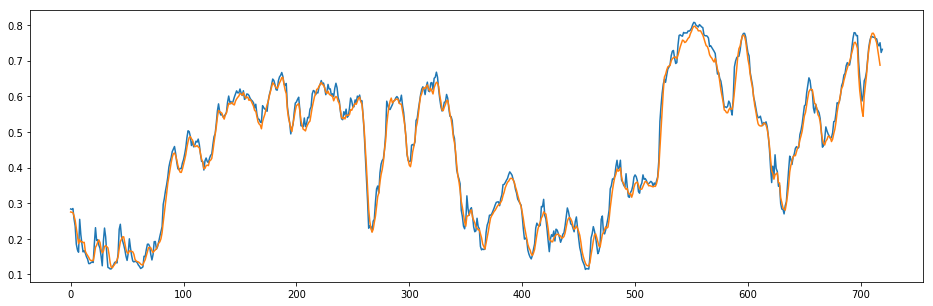

In [122]:
test_predict_t3 = extend_prediction(model, test_x, t = 2)
test_predict_t3_mw = scaler.inverse_transform(test_predict_t3)
test_predict_t3_ratio = [renewables / (renewables + non_renewables) for renewables, non_renewables in test_predict_t3_mw]

plt.plot(real['ratio'])
plt.plot(savgol_filter(test_predict_t3_ratio[-717:], lookback, 1))
plt.show()

* with a lookback of 5, t+3 prediction is still possible
* filter reduces jitter

### References

* https://keras.io/getting-started/sequential-model-guide/
* https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/
* https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
* https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
